In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

# Basic CNN model
class CNN(nn.Module):
    def __init__(self, conv_layers, numhidden, input_dim, dropout):
        super(CNN, self).__init__()
        layers = []
        input_channels=1
        for i in range(conv_layers):
            layers.append(nn.Conv2d(input_channels, 32, kernel_size=3))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            input_channels=32
            input_dim -= 2
            input_dim /= 2
            input_dim = int(input_dim)
            if(input_dim <= 2): break
        if(dropout > 0): layers.append(nn.Dropout(p=dropout))
        self.conv = nn.Sequential(*layers)
        self.fc1 = nn.Linear(32*input_dim*input_dim, numhidden)
        self.fc2 = nn.Linear(numhidden, 4)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

In [38]:
import numpy as np

# Retrieving OCTMNIST
octmnist = np.load('octmnist.npz')
octmnist_train = octmnist['train_images']
labels_train = octmnist['train_labels']
octmnist_val = octmnist['val_images']
labels_val = octmnist['val_labels']
octmnist_test = octmnist['test_images']
labels_test = octmnist['test_labels']

images = np.concatenate((octmnist_train, octmnist_val, octmnist_test), axis=0)
labels = np.concatenate((labels_train, labels_val, labels_test), axis=0)


data_train = images[: int(0.7*(images.shape[0]))]
labels_train = labels[: int(0.7*(labels.shape[0]))]
data_val = images[int(0.7*(images.shape[0])) : ]
labels_val = labels[int(0.7*(labels.shape[0])) : ]

# Normalize Pixel Values
data_train = data_train/255.0
data_val = data_val/255.0

data_train = data_train.reshape((-1, 1, 28, 28))
data_val = data_val.reshape((-1, 1, 28, 28))

print(f'Training set: {data_train.shape}, {labels_train.shape}')
print(f'Validation set: {data_val.shape}, {labels_val.shape}')

Training set: (76516, 1, 28, 28), (76516, 1)
Validation set: (32793, 1, 28, 28), (32793, 1)


In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_train = torch.tensor(data_train, dtype=torch.float, device=device)
labels_train = torch.tensor(labels_train, dtype=torch.long, device=device)
data_val = torch.tensor(data_val, dtype=torch.float, device=device)
labels_val = torch.tensor(labels_val, dtype=torch.long, device=device)

train = TensorDataset(data_train, labels_train)
val = TensorDataset(data_val, labels_val)

train_loader = DataLoader(train, batch_size=128, shuffle=True)
val_loader = DataLoader(val, batch_size=128, shuffle=True)

(3, 32, 242)


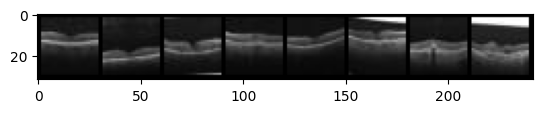

Labels :- 3	3	1	0	2	2	0	0


In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:8].cpu()
labels = labels[:8].cpu()

imshow(torchvision.utils.make_grid(images))
print('Labels :- ' + '\t'.join(f'{labels[j].item()}' for j in range(8)))

In [53]:
# Model Evaluator
def evaluate_model(model, epochs=3):
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            data = data.to(device)
            target = target.view(-1)
            target = target.to(target)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
    # Validate the model
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.view(-1)
            target = target.to(target)
            
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    accuracy = correct / len(val_loader.dataset)
    return accuracy

In [59]:
# Searching algorithm -- implements random search strategy
def search(num_trials, search_space, input_dim):
    results = []
    for _ in range(num_trials):
        conv_layers = torch.randint(search_space['conv_layers'][0], search_space['conv_layers'][-1], (1,)).item()
        numhidden = torch.randint(search_space['numhidden'][0], search_space['numhidden'][-1], (1,)).item()
        dropout = search_space['dropout'][torch.randint(0, 4, (1,))]
    
        cnn = CNN(conv_layers, numhidden, input_dim, dropout)
        cnn.to(device)
        accuracy = evaluate_model(cnn)
        results.append((conv_layers, numhidden, dropout, accuracy))

    return results

In [60]:
# Search space -- denotes the choices of parameters the basic model can take
search_space = {
    'conv_layers' : (1, 5),
    'numhidden' : (16, 512),
    'dropout' : (0, 0.2, 0.5, 0.8)
}
results = search(num_trials=15, search_space=search_space, input_dim=data_train.shape[2])
for config in results:
    print(f"Conv layers: {config[0]}, Hidden units: {config[1]}, Dropout: {config[2]}, Accuracy: {config[3]:.4f}")

Conv layers: 2, Hidden units: 219, Dropout: 0.2, Accuracy: 0.8193
Conv layers: 2, Hidden units: 261, Dropout: 0.2, Accuracy: 0.8089
Conv layers: 4, Hidden units: 264, Dropout: 0.2, Accuracy: 0.7949
Conv layers: 1, Hidden units: 98, Dropout: 0.8, Accuracy: 0.7679
Conv layers: 2, Hidden units: 34, Dropout: 0, Accuracy: 0.8043
Conv layers: 2, Hidden units: 31, Dropout: 0.8, Accuracy: 0.7726
Conv layers: 4, Hidden units: 357, Dropout: 0.8, Accuracy: 0.3413
Conv layers: 2, Hidden units: 377, Dropout: 0.2, Accuracy: 0.8097
Conv layers: 3, Hidden units: 272, Dropout: 0.5, Accuracy: 0.8018
Conv layers: 4, Hidden units: 435, Dropout: 0.8, Accuracy: 0.3413
Conv layers: 4, Hidden units: 431, Dropout: 0.5, Accuracy: 0.8074
Conv layers: 1, Hidden units: 310, Dropout: 0, Accuracy: 0.8002
Conv layers: 2, Hidden units: 475, Dropout: 0.8, Accuracy: 0.7930
Conv layers: 2, Hidden units: 85, Dropout: 0.5, Accuracy: 0.7925
Conv layers: 1, Hidden units: 237, Dropout: 0.5, Accuracy: 0.7985
